# Planify - Graph Neural Network

### Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
    <ul>
        <li><a href="#Imports">Imports</a></li>
        <li><a href="#func">Functions used</a></li>
    </ul>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#model">GNN Model</a></li>
    <ul>
        <li><a href="#dataLoader">Data Loader</a></li>
        <li><a href="#archi">Architecture</a></li>
        <li><a href="#train">Training</a></li> 
        <li><a href="#eval">Evaluation</a></li>
    </ul>
</ul>

<a id='intro'></a>
## Introduction

> This notebook getting garphs in the Networkx format from the `Creating Graphs` notebook. And its main goal is to make the GNN model.

In [1]:
# Used for vsCode only to show tqdm process
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

<a id='Imports'></a>
### Imports

In [2]:
# Only for kaggle
# !pip install torch_geometric

In [3]:
# Not included packages in kaggle

# Install torch_geometric
# !pip install /kaggle/input/torch-geometric/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl -q
# !pip install /kaggle/input/torch-geometric/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl -q

# # # library for getting distinct colores
# !pip install distinctipy -q

In [4]:
# for data wrangling
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import distinctipy
import random
from torch_geometric.utils import from_networkx

# to show advance in for loops
from tqdm import tqdm

# Using pytorch geometric
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset
import torch_geometric.transforms as T


# For the GNN model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool


# for my pc [linux]
# url = '/media/mo/DATA/Grad/Planify_Dataset/Graph/Planify_Graphs.pkl'

# for my pc [windows]
# url = "D:\Grad\Planify_Dataset\Graph\Planify_Graphs.pkl"
url_real = "D:\Grad\Planify_Dataset\Graph\graphs\Graphs_real.pkl"
url_boundary = r"D:\Grad\Planify_Dataset\Graph\graphs\boundaries.pkl"

# for kaggle
# url = '/kaggle/input/planify-graphs/Planify_Graphs.pkl'

<a id='func'></a>
### Functions used

In [5]:
geoms_columns = ['inner', 'living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'wall-in',
                    'outer_wall', 'front', 'inner_wall', 'interior',
                   'front_door', 'outer_wall', 'entrance']

N = len(geoms_columns)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(geoms_columns)}

In [6]:
def draw_graph(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}
    
    scales = [G.nodes[node]['roomSize'] * 10000 for node in G] 
    colormap = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    
    nx.draw(G, pos=pos, node_size=scales, node_color=colormap, with_labels=True, font_size=12)
    
    # Drawing the graph inside a good boundary.
    x_coords  = [pos[node][0] for node in pos]
    y_coords  = [pos[node][1] for node in pos]
    threshold = max(scales) / 100
    
    plt.xlim(min(x_coords) - threshold, max(x_coords) + threshold)
    plt.ylim(min(y_coords) - threshold, max(y_coords) + threshold)


def draw_graph_boundary(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['centroid'][0], -G.nodes[node]['centroid'][1])  for node in G.nodes}
    
    door_color = '#90EE90'
    other_nodes_color = '#0A2A5B'
    color_map = [door_color if G.nodes[node]['type'] == 1 else other_nodes_color for node in G.nodes]
    
    nx.draw(G, pos=pos, with_labels=True, node_color=color_map, font_color='w', font_size=12)
    



# For statistics
def get_max_min_x_y(graphs):
    max_x = 0
    max_y = 0
    min_x = float('inf')
    min_y = float('inf')
    
    for G in tqdm(graphs, desc="Getting maximum x, y", total=len(graphs)):
        max_x_in_graph = G.x.T[1].max().item()
        max_y_in_graph = G.x.T[2].max().item()
        
        min_x_in_graph = G.x.T[1].min().item()
        min_y_in_graph = G.x.T[2].min().item()
        
        if max_x_in_graph > max_x:
            max_x = max_x_in_graph
        if max_y_in_graph > max_y:
            max_y = max_y_in_graph
            
        if min_x_in_graph < min_x:
            min_x = min_x_in_graph
        if min_y_in_graph < min_y:
            min_y = min_y_in_graph
            
    values = {'max_x': max_x, 'max_y': max_y, 'min_x': min_x, 'min_y': min_y}
    return values


def get_all_x_y(Graphs_pyTorch):
    """Get all values of x and y from all graphs
        Input: list of graphs
        Output: x and y as pandas series
    """
    x = []
    y = []

    for G in tqdm(Graphs_pyTorch, desc="getting all Xs, Ys", total=len(Graphs_pyTorch)):
        for i in range(len(G.x)):
            x.append(G.x[i][1].item())
            y.append(G.x[i][2].item())

    x = pd.Series(x)
    y = pd.Series(y)

    return x, y

def boxplot_centrValues(x, y):
    fig, ax = plt.subplots()

    # Plot the boxplots
    ax.boxplot([x, y])

    # Set the xtick labels
    ax.set_xticklabels(['x', 'y'])

    # Add axis labels and title
    ax.set_xlabel('Data')
    ax.set_ylabel('Value')
    ax.set_title('Boxplot of x and y in all graphs')

    # Show the plot
    plt.show()
    

def plot_histograms(x, y):
    x.hist(density=True, bins=100, alpha=0.6, label='x');
    y.hist(density=True, bins=100, alpha=0.3, label='y');
    plt.legend();
    plt.title('Distribution of x and y');

<a id='wrangling'></a>
## Data wrangling


In [7]:
with open(url_real, 'rb') as f:
    Graphs = pickle.load(f)
    
G = Graphs[1911]
print(G)

Graph with 8 nodes and 13 edges


> Considering boundaries

In [8]:
with open(url_boundary, 'rb') as f:
    boundaries = pickle.load(f)
    
b = boundaries[1911]
print(b)

Graph with 9 nodes and 9 edges


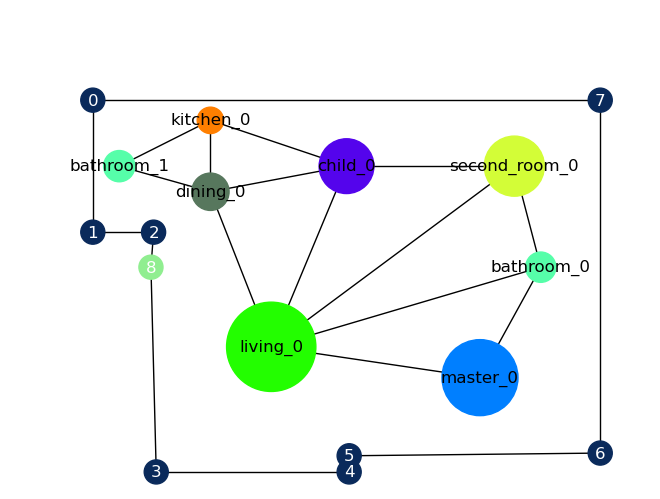

In [9]:
draw_graph_boundary(b)
draw_graph(G)

In [10]:
# Converting networkx graphs to pytorchGeo graphs
features = ['roomType_embd', 'actualCentroid_x', 'actualCentroid_y']
Graphs_pyTorch = []
for G in tqdm(Graphs):
    G_new = from_networkx(G, group_node_attrs=features, group_edge_attrs=['distance'])
    # Normalizing feature matrix (x)
    # G_new = T.NormalizeFeatures()(G_new)
    
    Graphs_pyTorch.append(G_new)

Graphs_pyTorch[0]

100%|██████████| 80787/80787 [00:46<00:00, 1753.79it/s]


Data(edge_index=[2, 18], roomType_name=[7], rec_w=[7], rec_h=[7], roomSize=[7], x=[7, 3], edge_attr=[18, 1])

In [11]:
# Converting networkx boundary graphs to pytorchGeo graphs
Boundaries_pyTorch = []
for b in tqdm(boundaries):
    b_new = from_networkx(b, group_node_attrs=['type', 'centroid'], group_edge_attrs=['distance'])
    
    Boundaries_pyTorch.append(b_new)

Boundaries_pyTorch[0]

100%|██████████| 80787/80787 [35:29<00:00, 37.93it/s]   


Data(edge_index=[2, 26], x=[13, 3], edge_attr=[26, 1])

> Statistics, To make normalization for x and y but to be able to get back to the real values

In [12]:
# getting maximum and minimum x, y for all graphs
get_max_min_x_y(Graphs_pyTorch)

Getting maximum x, y: 100%|██████████| 80787/80787 [00:05<00:00, 14763.21it/s]


{'max_x': 239.5, 'max_y': 237.5, 'min_x': 16.0, 'min_y': 17.0}

In [13]:
x, y = get_all_x_y(Graphs_pyTorch)
x.max(), y.max(), x.min(), y.min()

getting all Xs, Ys: 100%|██████████| 80787/80787 [00:06<00:00, 11917.60it/s]


(239.5, 237.5, 16.0, 17.0)

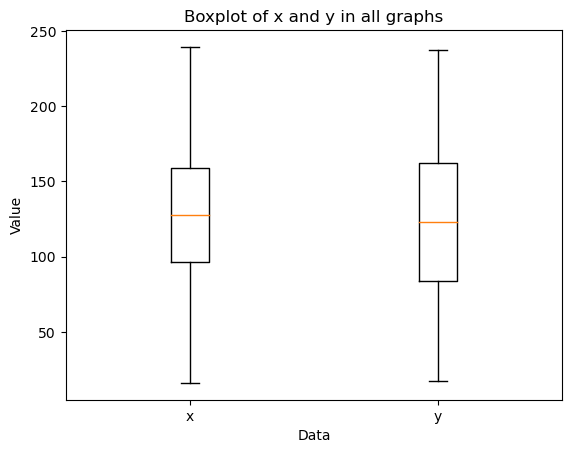

In [14]:
# making box plot for x and y for the graphs
boxplot_centrValues(x, y)

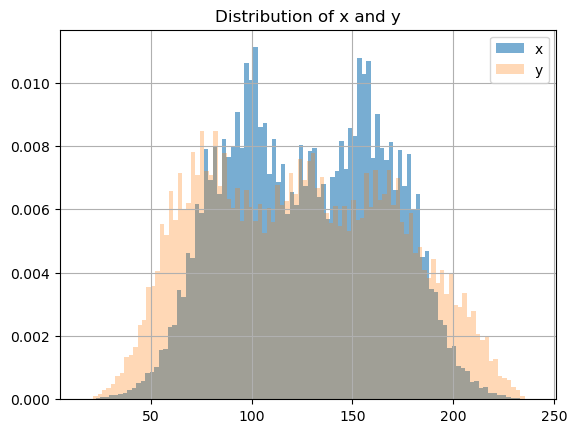

In [15]:
plot_histograms(x, y)

> And we saw the box plots so there is no outliers, and the distribution is normal
> 
> We will use z-score normalization, by taking a general mean and std for each of x and y

In [16]:
# print(f"Maximun x: {max_x}, Maximum y: {max_y}, Minimum x: {min_x}, Minimum y: {min_y}")
print("And we saw the box plots so there is no outliers, and the distribution is normal")
x_mean = x.mean()
y_mean = y.mean()
x_std  = x.std()
y_std  = y.std()
print("We will use z-score normalization")

And we saw the box plots so there is no outliers, and the distribution is normal
We will use z-score normalization


> There are many types of `rooms` but we will give them a defualt number = 1.
> So, also we will decrease the embedings to be between 0:6

In [17]:
print(f'Befor: G_1 embedings are: {Graphs_pyTorch[1].x}')
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    for j ,value in enumerate(G.x):
        type_ = int(value[0].item())
        
        if type_ in [1, 4, 5, 6, 7, 8]:
            G.x[j][0] = 1
        
        # making all labels from 0 to 6 only to help one_hotting
        elif type_ == 9:
            G.x[j][0] = 4
        elif type_ == 10:
            G.x[j][0] = 5
        elif type_ == 11:
            G.x[j][0] = 6


print(f'After: G_1 embedings are: {Graphs_pyTorch[1].x}')

Befor: G_1 embedings are: tensor([[  0.0000,  81.9371, 137.1722],
        [  1.0000, 181.5403, 165.1201],
        [  3.0000, 120.7426, 100.7954],
        [  7.0000, 132.6687, 167.8575],
        [  7.0000, 152.0459, 100.5418],
        [  3.0000, 192.0000, 127.0000],
        [  2.0000,  59.5000,  55.5000],
        [  9.0000,  77.0000, 210.5000]])


100%|██████████| 80787/80787 [00:06<00:00, 12104.89it/s]

After: G_1 embedings are: tensor([[  0.0000,  81.9371, 137.1722],
        [  1.0000, 181.5403, 165.1201],
        [  3.0000, 120.7426, 100.7954],
        [  1.0000, 132.6687, 167.8575],
        [  1.0000, 152.0459, 100.5418],
        [  3.0000, 192.0000, 127.0000],
        [  2.0000,  59.5000,  55.5000],
        [  4.0000,  77.0000, 210.5000]])


> Normalization for the centroids columns & hot encoding the type one for the graphs data.

In [18]:
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    x = G.x # The feature matrix
    for i in [1, 2]:
        # mean = torch.mean(x[:, i])
        # std  = torch.std(x[:, i])
        if i == 1:
            mean = x_mean
            std  = x_std
        else:
            mean = y_mean
            std  = y_std
            
        normalized_column = (x[:, i] - mean) / std
        G.x[:, i] = normalized_column
    
    # One hot encoding for the first column [type of rooms]
    first_column_encodings = F.one_hot(G.x[:, 0].long(), 7)
    
    G.x = torch.cat([first_column_encodings, G.x[:, 1:]], axis=1)

100%|██████████| 80787/80787 [00:13<00:00, 5897.01it/s]


In [19]:
print(f"Now, we could return back to real values: {Graphs_pyTorch[1].x.T[-2] * x_std + x_mean}")

Now, we could return back to real values: tensor([ 81.9371, 181.5403, 120.7426, 132.6687, 152.0459, 192.0000,  59.5000,
         77.0000])


> Normalizing the centroid of the boundaries

In [20]:
x, y = get_all_x_y(Boundaries_pyTorch)
x.max(), y.max(), x.min(), y.min()

getting all Xs, Ys: 100%|██████████| 80787/80787 [00:11<00:00, 6876.35it/s]


(245.0, 244.0, 12.0, 11.0)

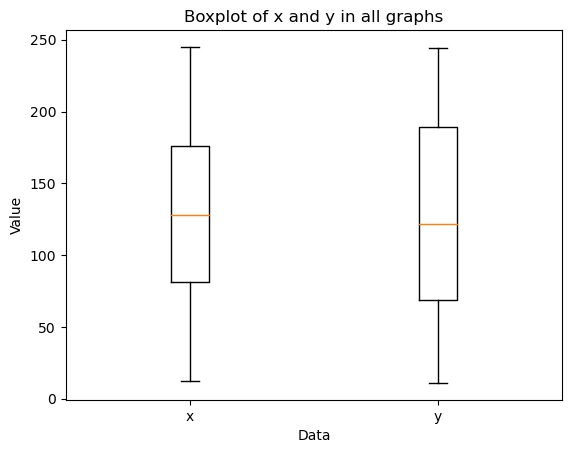

In [21]:
boxplot_centrValues(x, y)

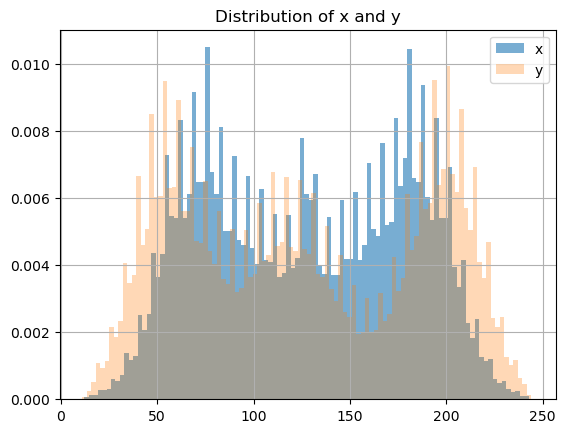

In [22]:
plot_histograms(x, y)

> And we saw the box plots so there is no outliers, and the distribution is normal
> 
> We will use z-score normalization, by taking a general mean and std for each of x and y

In [23]:
# print(f"Maximun x: {max_x}, Maximum y: {max_y}, Minimum x: {min_x}, Minimum y: {min_y}")
print("And we saw the box plots so there is no outliers, and the distribution is normal")
x_mean = x.mean()
y_mean = y.mean()
x_std  = x.std()
y_std  = y.std()
print("We will use z-score normalization")

And we saw the box plots so there is no outliers, and the distribution is normal
We will use z-score normalization


In [24]:
for b in tqdm(Boundaries_pyTorch, total=len(Boundaries_pyTorch)):
    x = b.x # The feature matrix
    for i in [1, 2]:
        if i == 1:
            mean = x_mean
            std  = x_std
        else:
            mean = y_mean
            std  = y_std
            
        normalized_column = (x[:, i] - mean) / std
        b.x[:, i] = normalized_column

100%|██████████| 80787/80787 [00:05<00:00, 14894.45it/s]


In [25]:
print(f"Now, we could return back to real values: {Boundaries_pyTorch[1].x.T[-2] * x_std + x_mean}")

Now, we could return back to real values: tensor([ 48.,  48., 106., 106., 208., 208., 172., 171.,  72.,  71., 100.],
       dtype=torch.float64)


> If we need to creat graphs with padding by the maximum number of nodes.

In [26]:
# # but we need to do some padding to our graphs to be all of the same number of nodes.
# padded_graphs = []
# for G in Graphs_pyTorch:
#     x          = G.x
#     y          = G.roomType_embd
#     edge_index = G.edge_index
#     edge_attr  = G.edge_attr
    
#     nu_nodes = x.shape[0]

#     padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
#     padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
#     train_mask   = torch.ones(nu_nodes)
#     train_mask   = torch.nn.functional.pad(train_mask, pad=(0, 8 - nu_nodes), mode='constant', value=0).to(bool)

#     data = Data(x = padded_x, y = padded_y, edge_index= G.edge_index, edge_attr = G.edge_attr, train_mask=train_mask)

#     padded_graphs.append(data)

# padded_graphs[0]

<a id='model'></a>
## GNN Model

<a id='dataLoader'></a>
### Data Loader

In [27]:
class Planify_Dataset(Dataset):
    def __init__(self, Graphs, Boundaries):
        self.Graphs = Graphs
        self.Boundaries = Boundaries
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def __len__(self):
        return len(self.Graphs)

    def __getitem__(self, index):
        G = self.Graphs[index].clone().to(self.device)
        B = self.Boundaries[index].clone().to(self.device)
        B.x = B.x.to(G.x.dtype)
        B.edge_index = B.edge_index.to(G.edge_index.dtype)
        B.edge_attr = B.edge_attr.to(G.edge_attr.dtype)
        
        # shuffling nodes inside the same graph
        permutation = torch.randperm(G.num_nodes).to(self.device)
        
        G.x = G.x[permutation]
        G.edge_index = permutation[G.edge_index]
        G.rec_w = G.rec_w[permutation]
        G.rec_h = G.rec_h[permutation]
        # G.edge_attr = G.edge_attr[permutation]
        
        # padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
        # padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
        graphs = {
            'G': G,
            'B': B
        }
        
        return graphs

In [28]:
edge = int(len(Graphs_pyTorch) * 0.8)

In [134]:
batch_size = 1
train_dataset = Planify_Dataset(Graphs_pyTorch[:edge], Boundaries_pyTorch[:edge])
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = Planify_Dataset(Graphs_pyTorch[edge:-10], Boundaries_pyTorch[edge:-10])
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = Planify_Dataset(Graphs_pyTorch[-10:], Boundaries_pyTorch[-10:])
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [135]:
# Saving model function
import os

# checkpoint_dir = '/kaggle/working/checkpoints'
# checkpoint_dir = '/media/mo/DATA/Grad/Planify_Dataset/Graph/checkpoints'
checkpoint_dir = "./checkpoints"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    

def save_checkpoint(model, optimizer, epoch):
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
    # Saving model each 15 epochs
    if epoch % 20 == 0:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch
        }, checkpoint_path)
        
        print('Model saved :)')

<a id='archi'></a>
### Architecture

In [137]:
from torch_geometric.nn import GlobalAttention
from torch_geometric.nn.dense import DenseGCNConv

class GATNet(torch.nn.Module):
    def __init__(self, num_graph_node_features, num_boundary_node_features):
        super(GATNet, self).__init__()
        
        self.graph_conv1 = GATConv(num_graph_node_features, 32)
        self.graph_conv2 = GATConv(32, 32, heads=8)
        self.graph_conv3 = GATConv(32*8, 64, heads=8)
        self.graph_conv4 = GATConv(64*8, 128, heads=8)
        self.graph_conv5 = GATConv(128*8, 128, heads=8)
        
        self.boundary_conv1 = GATConv(num_boundary_node_features, 32)
        self.boundary_conv2 = GATConv(32, 32, heads=8)
        self.boundary_conv3 = GATConv(32*8, 64, heads=8)
        self.boundary_conv4 = GATConv(64*8, 128, heads=8)
        self.boundary_conv5 = GATConv(128*8, 128, heads=8)
        
        inputs_lin1 = 128*8 + 128*8 + num_graph_node_features # Output of conv5 + output of boundary_conv5 + step connection from real nodes.
        self.lin1 = torch.nn.Linear(inputs_lin1, 32)
        self.lin2 = torch.nn.Linear(32, 2)
        
        
        self.boundary_pool = torch.nn.AdaptiveAvgPool1d(1)

    def forward(self, graph, boundary):
        x_graph, g_edge_index, g_edge_attr, g_batch = graph.x, graph.edge_index, graph.edge_attr, graph.batch
        x_boundary, b_edge_indexy, b_edge_attr, b_batch = boundary.x, boundary.edge_index, boundary.edge_attr, boundary.batch
        
        NUM_OF_NODES = x_graph.shape[0]
        # During testing, as we input only one graph.
        if g_batch == None:
            g_batch = torch.zeros(x_graph.shape[0], dtype=torch.long)
        if b_batch == None:
            b_batch = torch.zeros(x_boundary.shape[0], dtype=torch.long)
        
        
        x_res = x_graph
        
        # Passing the graph throught a message passing to embed its features
        x_graph = F.relu(self.graph_conv1(x_graph, g_edge_index))
        x_graph = F.relu(self.graph_conv2(x_graph, g_edge_index))
        x_graph = F.relu(self.graph_conv3(x_graph, g_edge_index))
        x_graph = F.relu(self.graph_conv4(x_graph, g_edge_index))
        x_graph = F.relu(self.graph_conv5(x_graph, g_edge_index))

        
        # Concatinate with step connection from real values.
        x_graph = torch.cat([x_graph, x_res], dim=1)
        
        # Passing the boundary throught a message passing to embed its features
        x_boundary = F.relu(self.boundary_conv1(x_boundary, b_edge_indexy))
        x_boundary = F.relu(self.boundary_conv2(x_boundary, b_edge_indexy))
        x_boundary = F.relu(self.boundary_conv3(x_boundary, b_edge_indexy))
        x_boundary = F.relu(self.boundary_conv4(x_boundary, b_edge_indexy))
        x_boundary = F.relu(self.boundary_conv5(x_boundary, b_edge_indexy))
        
        # Pooling the bounadry to 1D vector by getting max value in each feature for all nodes.
        x_boundary_pooled = F.max_pool1d(x_boundary.transpose(0, 1), kernel_size=x_boundary.shape[0]).view(1, -1)
        
        # Concatinating the graph & the boundary
        x = torch.cat([x_graph, x_boundary_pooled.repeat(NUM_OF_NODES, 1)], dim=1)
        
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        
        return x

num_graph_node_features = Graphs_pyTorch[0].x.shape[1]
num_boundary_node_features = Boundaries_pyTorch[0].x.shape[1]

model = GATNet(num_graph_node_features, num_boundary_node_features)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# to monitor the loss & accuracy.
errors = []
acc = []

model

GATNet(
  (graph_conv1): GATConv(9, 32, heads=1)
  (graph_conv2): GATConv(32, 32, heads=8)
  (graph_conv3): GATConv(256, 64, heads=8)
  (graph_conv4): GATConv(512, 128, heads=8)
  (graph_conv5): GATConv(1024, 128, heads=8)
  (boundary_conv1): GATConv(3, 32, heads=1)
  (boundary_conv2): GATConv(32, 32, heads=8)
  (boundary_conv3): GATConv(256, 64, heads=8)
  (boundary_conv4): GATConv(512, 128, heads=8)
  (boundary_conv5): GATConv(1024, 128, heads=8)
  (lin1): Linear(in_features=2057, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=2, bias=True)
  (boundary_pool): AdaptiveAvgPool1d(output_size=1)
)

In [138]:
# Hyperparameters
learning_rate = 0.001
nu_epochs = 2

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.972)

# def scheduler(epoch, lr)
#     if epoch < 20:
#         return lr
#     else:
#         return lr * 0.99

<a id='train'></a>
### Training


In [139]:
for epoch in range(nu_epochs):
    running_loss = 0.0
    train_acc    = 0.0
    for i, data in tqdm(enumerate(train_loader), desc='Planifying', total=len(train_loader)):
        optimizer.zero_grad()
        # Forward pass
        graph, boundary = data['G'], data['B']
        
        logits    = model(graph, boundary)
        # computing loss through crossEntropy loss function
        targets = torch.cat((graph.rec_w.unsqueeze(1), graph.rec_h.unsqueeze(1)), dim=1)
        # print(logits.shape, targets.shape)
        loss = criterion(logits, targets)
        
        # Backward pass
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        # current_lr = optimizer.param_groups[0]['lr']
        # optimizer = torch.optim.Adam(model.parameters(), lr=scheduler(epoch, current_lr))
        
        # Monitoring
        running_loss += loss.item()
        # train_acc += (torch.argmax(logits, 1).flatten() == data.roomType_embd).type(torch.float).mean().item()
        lr = optimizer.param_groups[0]['lr']
    
    # model.regreetor.reset_parameters()
    
    print(targets[0, :])
    print(logits[0, :])
    
    errors.append(running_loss/batch_size)
    # acc.append(train_acc/batch_size)
    
    # Updating scheduler each 15 epochs.
    # scheduler.step()
    
    # Saving the model.
    save_checkpoint(model, optimizer, epoch)
    
    # Monitoring and printing.
    batch_size = len(train_loader)
    print(f'Epoch: {epoch + 1}/{nu_epochs} | lr: {lr} | avg_loss: {running_loss/batch_size:.5f}')

Planifying: 100%|██████████| 64629/64629 [58:49<00:00, 18.31it/s]  


tensor([128.,  76.], device='cuda:0')
tensor([110.1447,  80.7645], device='cuda:0', grad_fn=<SliceBackward0>)
Model saved :)
Epoch: 1/2 | lr: 0.001 | avg_loss: 209.82221


Planifying: 100%|██████████| 64629/64629 [1:03:24<00:00, 16.99it/s]

tensor([53., 46.], device='cuda:0')
tensor([43.8317, 49.2730], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 2/2 | lr: 0.001 | avg_loss: 145.16769


{'G': DataBatch(edge_index=[2, 18], roomType_name=[1], rec_w=[7], rec_h=[7], roomSize=[7], x=[7, 9], edge_attr=[18, 1], batch=[7], ptr=[2]), 'B': DataBatch(edge_index=[2, 26], x=[13, 3], edge_attr=[26, 1], batch=[13], ptr=[2])}


KeyError: 0

In [143]:
for l in test_loader:
    g = l['G']
    b = l['B']
    
    res = model(g, b)
    break


graph = Graphs_pyTorch[0]
target = torch.cat((graph.rec_w.unsqueeze(1), graph.rec_h.unsqueeze(1)), dim=1)
target, res.int()

(tensor([[124., 134.],
         [ 41.,  55.],
         [ 23.,  38.],
         [ 24.,  33.],
         [ 38.,  38.],
         [ 33.,  38.],
         [ 24.,  16.]], device='cuda:0'),
 tensor([[ 43,  59],
         [ 49,  17],
         [ 33,  33],
         [ 39,  49],
         [ 24,  28],
         [ 69, 121]], device='cuda:0', dtype=torch.int32))